<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a2/Part_A_ii_ensemlble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

#### Show the environment

In [ ]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu
print()
print()
print('=' * 80)
print()
print()
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5


Tue Apr 27 11:12:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics, model_selection
from statistics import mean, median
from time import perf_counter
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn import linear_model
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFwe, chi2, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

#### Setup logging

In [ ]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import zipfile
import h5py
import gc
import IPython

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

#### Mount Google Drive And Copy Files

In [ ]:
drive.mount('/content/gdrive')

if (os.path.exists("/root/imagedata")):
    ret = shutil.rmtree("/root/imagedata")
os.mkdir("/root/imagedata")
shutil.copyfile( \
    "/content/gdrive/MyDrive/DeepLearningAssignment2/earth_data.zip",
    "/root/imagedata/earth_data.zip")

!cd /root/imagedata && unzip earth_data.zip && rm -f earth_data.zip

Mounted at /content/gdrive
Archive:  earth_data.zip
  inflating: earth_data.h5           


## Code to plot graphs and remember histories

This class is a helper class to aggregate *history* data from all runs.
This just makes plotting simpler.

In [ ]:
class Entry:
    def __init__(self, loss, val_loss, accuracy, val_accuracy, best_accuracy, best_loss):
        self.loss = loss
        self.val_loss = val_loss
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy
        self.best_accuracy = best_accuracy
        self.best_loss = best_loss

class Plot:
    def __init__(self):
        self.history = {}
        self.colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', \
                       'tab:orange', 'tab:green', 'tab:red', 'tab:purple', \
                       'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    def plot_history(self, history, N_EPOCHS, name, show=True):
        if show:
            N_EPOCHS = len(history.history["loss"])
            plt.rcParams["figure.figsize"] = (20, 10)
            plt.xticks(np.arange(0, N_EPOCHS+1, 1.0))
            plt.plot(np.arange(0, N_EPOCHS), history.history["loss"], label="train loss", color='blue', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_loss"], label="val loss", color='blue', linestyle='dashdot')
            plt.plot(np.arange(0, N_EPOCHS), history.history["accuracy"], label="train acc", color='red', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_accuracy"], label="val acc", color='red', linestyle='dashdot')
            plt.legend()
            plt.show()
        best_val_acc = max(history.history['val_accuracy'])
        index_best_val_accuracy = history.history['val_accuracy'].index(best_val_acc)
        best_val_loss = min(history.history['val_loss'])
        index_best_val_loss = history.history['val_loss'].index(best_val_loss)
        if show:
            print(f"Best validation accuracy: {best_val_acc}, epoch = {index_best_val_accuracy}")
            print(f"Best validation loss: {best_val_loss}, epoch = {index_best_val_loss}")
        entry = Entry(\
                      loss=history.history["loss"],\
                      val_loss=history.history["val_loss"],\
                      accuracy=history.history["accuracy"],\
                      val_accuracy=history.history["val_accuracy"],\
                      best_accuracy=best_val_acc,
                      best_loss=best_val_loss)
        self.history[name] = entry
        gc.collect()

    def superplot(self):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
            innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
            innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
            innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
            i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()



## Extract train and test instances

In [ ]:
def loadDataH5():
    with h5py.File('/root/imagedata/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
        return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()
trainX = trainX / 255.0
valX = valX / 255.0

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


## Callbacks

In [ ]:
def decay_after_runs(N):
    # After N runs decrease the learning rate by 1/e every time
    NRUNS = N
    def learning_rate_scheduler(epoch, lr):
        # We're sneaking this in, since this will be called at every epoch
        # it also gives us a good way to force calls to gc() within the fit
        # function
        gc.collect()
        if NRUNS < 0 or epoch < NRUNS:
            return lr
        else:
            print(f"Learning Rate: {lr} --> {lr * tf.math.exp(-1.0)}")
            return lr * tf.math.exp(-0.1)
    return learning_rate_scheduler
lr_callback = tf.keras.callbacks.LearningRateScheduler(decay_after_runs(20))

early_stopping = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=3,
                                                  verbose=1,
                                                  mode='auto')
early_stopping2 = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=10,
                                                  verbose=1,
                                                  mode='auto')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(\
                                                 monitor='val_loss',\
                                                 factor=0.5,\
                                                 patience=3,\
                                                 min_lr=0.001)

term_on_nan = tf.keras.callbacks.TerminateOnNaN()

DRIVE_FOLDER = "/content/gdrive/MyDrive/DeepLearningAssignment2"

def get_checkpoint_callback(name):
    checkpoint_filepath = f"{DRIVE_FOLDER}/ckp-{name}"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback


def get_callbacks_decay_after(N, name=None):
    if N == -2:
        # If this is true the learning rate is not decayed
        # but early stopping has more patience
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(-1)),
                        early_stopping2,
                        term_on_nan,
                        ]
    else:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(N)),
                        early_stopping,
                        term_on_nan,
                        ]
    if N > 0:
        callback_array.append(reduce_lr)
    if None != name:
        callback_array.append(get_checkpoint_callback(name))
    return callback_array

# Question 1 Part A

## 1. Build a model generator

In [ ]:
import random
random.seed(5)
import gc
class ModelFactory:
    @staticmethod
    def get_conv_layer(depth, inshape=None, force_stride_size=False):

        # This method adds a convolutional layer with (possibly) a pooling layer
        # Everyting is based on random numbers, and a choice is made from
        # a pre-determined range of values

        out_layers = []

        # Randomly choose the stride size and filter size
        filter_size = random.choice([2, 3, 4, 5])
        stride_size = random.choice([1, 2, 3])
        stride_size = stride_size if stride_size < filter_size else filter_size

        # Sometimes the choice of stride size taken up randomly
        # will be such that it doesn't match and causes an error. We could
        # write some logic to handle this, but it is easier to just fail
        # and let the caller call it again with a force_stride_size set
        #
        # In case there is an exception, the caller will
        # set this and call again
        stride_size = 1 if force_stride_size else stride_size

        stride_size = (stride_size, stride_size, )
        filter_shape = tuple([filter_size, filter_size,])
        act_fn = random.choice(['tanh', 'relu', 'sigmoid', 'selu', 'elu'])
        pd = random.choice(['same', 'valid'])

        # Create the convolutional layer
        if None != inshape:
            conv_layer = tf.keras.layers.Conv2D(\
                                                depth,\
                                                filter_shape,\
                                                padding=pd,\
                                                input_shape=inshape,\
                                                strides=stride_size,\
                                                activation=act_fn)
        else:
            conv_layer = tf.keras.layers.Conv2D(\
                                                depth,\
                                                filter_shape,\
                                                padding=pd,\
                                                strides=stride_size,\
                                                activation=act_fn)
        out_layers.append(conv_layer)

        # randomly choose whether max pooling is to be applied or not
        if random.choice([True, False]):
            # If pooling is to be applied, randomly choose the pool size
            pool_size = random.choice([2, 3, 4])
            out_layers.append(tf.keras.layers.MaxPooling2D(\
                                                           pool_size,\
                                                           pool_size,))
        
        # Randomly determine whether dropout is to be used or not
        if random.choice([True, False]):
            out_layers.append(tf.keras.layers.SpatialDropout2D(0.25))

        return out_layers

    @staticmethod
    def generate_model_internal(inshp, nlabels:int, modelname:str, fss:bool):
        layer_neurons = []

        # Randomly choose the number of convolutional layers
        n_conv_layers = random.choice([1, 2, 3,])
        layer_depth = sorted([\
                random.choice([32, 64, 128, 256, 512, 1024]) \
                    for _ in range(n_conv_layers)])

        # Ensure that the layer depth keeps on increasing
        # Fix if required
        for i in range(1, len(layer_depth)):
            if layer_depth[i] <= layer_depth[i-1]:
                layer_depth[i] = 2 * layer_depth[i-1]

        # Add the first Convolutional layer
        model = tf.keras.Sequential(name=modelname)
        for lyr in ModelFactory.get_conv_layer(layer_depth[0], inshp, force_stride_size=fss):
            model.add(lyr)
        
        # Add zero or more additional convoluationa layer
        for d in layer_depth[1:]:
            for lyr in ModelFactory.get_conv_layer(d, inshape=None, force_stride_size=fss):
                model.add(lyr)

        # Flatten
        model.add(tf.keras.layers.Flatten())

        # Add zero or more dense layers
        n_dense = random.choice([0, 1, 2])
        for _ in range(n_dense - 1):
            act_fn = random.choice(['tanh', 'relu', 'sigmoid', 'selu', 'elu'])
            layer = tf.keras.layers.Dense(\
                                random.choice([32, 64, 128, 256, 512]),
                                activation=act_fn)
            model.add(layer)
            if random.choice([True, False]):
                layer = tf.keras.layers.Dropout(0.25)
                model.add(layer)
        
        # Add the final Dense layer
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        
        return model

    @staticmethod
    def print_model(model):
        plot = tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())

    @staticmethod
    def generate_model_size(inshp:tuple, nlabels:int, modelname:str, max_params:int):
        # This is a wrapper method. Randomly generated models can become
        # too large with too many parameters.
        # An attempt will be made to keep the number of parameters
        # less than what is specified, but there is no guarantee.
        # However, this ensures that at least most of the models in the
        # 10 models are small and easy to train
        if (-1 == max_params):
            try:
                model = ModelFactory.generate_model_internal(\
                                                            inshp,\
                                                            nlabels,\
                                                            modelname,\
                                                            False)
            except:
                model = ModelFactory.generate_model_internal(\
                                                            inshp,\
                                                            nlabels,\
                                                            modelname,\
                                                            True)
            ModelFactory.print_model(model)
            return model
        else:
            # Make 10 attempts to generate a model with the number of
            # trainable params less than the one specified
            for i in range(10):
                gc.collect()
                logging.debug(f"Attempt {i}")
                try:
                    model = ModelFactory.generate_model_internal(\
                                                                inshp,\
                                                                nlabels,\
                                                                modelname,
                                                                False)
                except:
                    model = ModelFactory.generate_model_internal(\
                                                                inshp,\
                                                                nlabels,\
                                                                modelname,
                                                                True)
                if model.count_params() < max_params:
                    ModelFactory.print_model(model)
                    gc.collect()
                    return model

                gc.collect()
            return None
    
    @staticmethod
    def generate_model(inshp:tuple, nlabels:int, modelname:str, max_params:int):
        """
        Tries to make a model with the number of trainable params less
        than the specified number. If it is not able to do so, it will
        create a model with a greater number regardless
        """
        model = ModelFactory.generate_model_size(\
                                                 inshp,\
                                                 nlabels,\
                                                 modelname,\
                                                 max_params)
        if None == model:
            model = ModelFactory.generate_model_size(\
                                                     inshp,\
                                                     nlabels,\
                                                     modelname,\
                                                     -1)
        return model

# Generate the Base Models

Generate 10 base models, try to eep the parameters less than 9.5 million

In [ ]:

def get_formatted_json(jsonstr):
    j = json.loads(jsonstr)
    return json.dumps(j, indent=4)

get_model_name = lambda n : f"ensemble-base-model-{n}"
get_model_json_filename = lambda n : f"save-ensemble-base-model-{n}.json"

import json
def generate_base_models(n_models):
    random.seed(5)
    n_classes = len(np.unique(np.concatenate((trainY, valY))))
    for i in range(n_models):
        modelname = get_model_name(i)
        filename = get_model_json_filename(i)
        model = ModelFactory.generate_model(trainX[0].shape, n_classes, modelname, 9_500_000)
        model_json = model.to_json()
        with open(f"{DRIVE_FOLDER}/{filename}", "w") as f:
            f.write(get_formatted_json(model_json))
            f.close()

# Train each model

In [ ]:
def train_model_internal(model, plot):
    print(model.summary())
    print()
    N_EPOCHS = 50
    model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
    if model.count_params() < 1_500_000:
        print("Using decay of learning reate")
        cb = get_callbacks_decay_after(5, model.name)
    else:
        print("Avoiding decay of learning reate")
        cb = get_callbacks_decay_after(-1, model.name)
    history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=cb)
    if plot:
        plot.plot_history(history, 100, model.name, show=False)

def train_model(i, plot):
    print('=' * 80)
    print('=' * 80)
    print(f"Training model {i}")
    print()
    fname = get_model_json_filename(i)
    fname = f"{DRIVE_FOLDER}/{fname}"
    with open(fname, "r") as f:
        jsonstr = f.read()
        model = tf.keras.models.model_from_json(jsonstr)
        train_model_internal(model, plot)

# Code to load and save models

This is necessary because we will use the final predictions from the best model
we found during training

In [ ]:
def load_model(n):
    fname = get_model_json_filename(n)
    fname = f"{DRIVE_FOLDER}/{fname}"
    with open(fname, "r") as f:
        jsonstr = f.read()
        model = tf.keras.models.model_from_json(jsonstr)
        model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
    return model

def load_model_weight(model, n):
    weight_file = f"{DRIVE_FOLDER}/ckp-{model.name}"
    model.load_weights(weight_file)

def get_predictions(model, X):
    x = model.predict(X)
    return x


# Routines to train, classify, save and use the secondary clasification scheme

In [ ]:
N_BASE_MODELS = 10

# Names of files where each set of outputs is stored after test
train_pred_fname = lambda i: f"{DRIVE_FOLDER}/train_pred_{i}.txt"
val_pred_fname = lambda i: f"{DRIVE_FOLDER}/val_pred_{i}.txt"

# Train all base models
def train_all_models(plot):
    for i in range(N_BASE_MODELS):
        train_model(i, plot)

# Run each test and train examples through a trained base model
# and save the output
def evaluate_and_save(i):
    print(f"--------------------- {i} -----------------------")
    model = load_model(i)
    load_model_weight(model, i)
    trainPred = get_predictions(model, trainX)
    valPred = get_predictions(model, valX)
    np.savetxt(train_pred_fname(i), trainPred, delimiter=',')
    np.savetxt(val_pred_fname(i), valPred, delimiter=',')
    gc.collect()

def evaluate_and_save_all():
    for i in range(N_BASE_MODELS):
        evaluate_and_save(i)

def get_train_predictions(N):
    ret = []
    for i in range(N):
        ret.append(np.loadtxt(train_pred_fname(i), delimiter=','))
    return ret

def get_val_predictions(N):
    ret = []
    for i in range(N):
        ret.append(np.loadtxt(val_pred_fname(i), delimiter=','))
    return ret

from sklearn.metrics import accuracy_score
def get_accuracy(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_true, y_pred)
    return acc

def get_ensemble_predictions(pred_array):
    # This combines the predictions from all the 10 base classifier
    # Into one prediction by summin over the probabilities from
    # each base classifier
    added = pred_array[0].copy()
    for a in pred_array[1:]:
        added = added + a
    # Scale it by hand, since these are a sum of N probabilities
    added = added / len(pred_array)
    return added

import pandas as pd
import seaborn as sns

# Use Random Forest to combine the results
from sklearn.ensemble import RandomForestClassifier
def rf_ensemble():
    val_accuracies = []
    train_accuracies = []
    model_names = []

    # Load the saved training predictions
    train_predictions = get_train_predictions(N_BASE_MODELS)

    # Get the ensemble prediction for the training
    #    by summing over the predictions for each base learner
    ensemble_train_features = get_ensemble_predictions(train_predictions)

    # Load the saved validation predictions
    val_predictions = get_val_predictions(N_BASE_MODELS)

    # Get the ensemble prediction for the validation
    #    by summing over the predictions for each base learner
    ensemble_val_features = get_ensemble_predictions(val_predictions)

    # Now we have 10 individual predictions from each classifier (10x9 features)
    # and one combined summed up prediction from each classifier (9 features)
    # Combine all of these together to form a super vector (99 features)
    for j in train_predictions:
        ensemble_train_features = np.append(ensemble_train_features, j, axis=1)
    for j in val_predictions:
        ensemble_val_features = np.append(ensemble_val_features, j, axis=1)

    rfc = RandomForestClassifier()
    rfc.fit(ensemble_train_features, trainY)
    val_pred = rfc.predict(ensemble_val_features)
    train_pred = rfc.predict(ensemble_train_features)
    return train_pred, val_pred,\
            accuracy_score(trainY, train_pred),\
            accuracy_score(valY, val_pred)

# Instead of using a fixed model for the secondary classification on the
# array of 99 features, try all models.
def ensemble_various_models():
    val_accuracies = []
    train_accuracies = []
    model_names = []

    def train_and_fit_model(m, trainX, trainY, valX, valY):
        m = m()
        m.fit(trainX, trainY)
        y_pred = m.predict(valX)
        val_acc = accuracy_score(valY, y_pred)
        return val_acc

    def plot_internal(model_names, model_accuracies, description):
        df = pd.DataFrame({'Model': model_names, 'Accuracy': model_accuracies})
        sns.barplot(data=df, x='Accuracy', y='Model', orient='h')
        plt.title(description)
        plt.show()

    basic_models = [
        ('DecisionTreeClassifier', lambda: Pipeline([('dt', DecisionTreeClassifier(random_state=1),)])),
        ('KNeighborsClassifier', lambda: Pipeline([('knn', KNeighborsClassifier(n_jobs=-1),)])),
        ('NearestCentroid', lambda: Pipeline([('nearestCentroid', NearestCentroid(),)])),
        ('NaiveBayes', lambda: GaussianNB()),
        ('SVC', lambda: Pipeline([('svc', SVC(random_state=1),)])),
        ('Random Forest', lambda: RandomForestClassifier(random_state=1, n_jobs=-1)),
        #('Gradient Boost', lambda: Pipeline([('pca', PCA(n_components=25),), ('gb',GradientBoostingClassifier(),)])),
        ('LDA', lambda: Pipeline([('pca', PCA(n_components=20),), ('lda', LinearDiscriminantAnalysis(),)])),
        ('QDA', lambda: Pipeline([('pca', PCA(n_components=20),), ('qda',QuadraticDiscriminantAnalysis(),)])),
        ('Logistic Regression', lambda: LogisticRegression(random_state=1, n_jobs=-1)),
        ('Ridge', lambda: Pipeline([('rc',RidgeClassifier(random_state=1),)])),
        ('Bagging', lambda: Pipeline([('bg', BaggingClassifier(random_state=1, n_jobs=-1),)])),
        #('SGD Classifier', lambda: Pipeline([('pca', PCA(n_components=100),), ('sgd', SGDClassifier(random_state=1),)])),
        ('SGD Classifier', lambda: SGDClassifier(random_state=1, n_jobs=-1, max_iter=2000)),
        ('Passive Aggressive', lambda: Pipeline([('pac', PassiveAggressiveClassifier(random_state=1, n_jobs=-1),)])),
    ]


    # Load the saved training predictions
    train_predictions = get_train_predictions(N_BASE_MODELS)

    # Get the ensemble prediction for the training
    #    by summing over the predictions for each base learner
    ensemble_train_features = get_ensemble_predictions(train_predictions)

    # Load the saved validation predictions
    val_predictions = get_val_predictions(N_BASE_MODELS)

    # Get the ensemble prediction for the validation
    #    by summing over the predictions for each base learner
    ensemble_val_features = get_ensemble_predictions(val_predictions)

    # Now we have 10 individual predictions from each classifier (10x9 features)
    # and one combined summed up prediction from each classifier (9 features)
    # Combine all of these together to form a super vector (99 features)
    for j in train_predictions:
        ensemble_train_features = np.append(ensemble_train_features, j, axis=1)
    for j in val_predictions:
        ensemble_val_features = np.append(ensemble_val_features, j, axis=1)

    # Now try all the models and see how they perform
    for (name, model) in basic_models:
        acc = train_and_fit_model(model, ensemble_train_features, trainY, ensemble_val_features, valY)
        print(f"{name:20s} : {acc}")
        model_names.append(name)
        val_accuracies.append(acc)
    for i, j in zip(model_names, val_accuracies):
        print(i, j)
    plot_internal(model_names, val_accuracies, 'Validation Accuracy Various Models')
    

def simple_ensemble():
    train_predictions = get_train_predictions(N_BASE_MODELS)
    val_predictions = get_val_predictions(N_BASE_MODELS)
    # Get the ensemble prediction for the training
    #    by summing over the predictions for each base learner
    ensemble_train_prediction = get_ensemble_predictions(train_predictions)
    # Get the ensemble prediction for the validation
    #    by summing over the predictions for each base learner
    ensemble_val_prediction = get_ensemble_predictions(val_predictions)

    # See how well this simple scheme performs
    return ensemble_train_prediction, ensemble_val_prediction, \
                    get_accuracy(trainY, ensemble_train_prediction),\
                    get_accuracy(valY, ensemble_val_prediction)

def ensemble_driver():
    val_accuracies = []
    train_accuracies = []
    model_names = []
    model_weights = []

    # Load the saved training predictions
    train_predictions = get_train_predictions(N_BASE_MODELS)


    # Load the saved validation predictions
    val_predictions = get_val_predictions(N_BASE_MODELS)


    # Get the accuracy for the validation predictions for each base models
    for n, i in enumerate(val_predictions):
        acc = get_accuracy(valY, i)
        val_accuracies.append(acc)

    _, _, se_train_acc, se_val_acc = simple_ensemble()

    # Append the validation accuracy of the ensemble
    val_accuracies.append(se_val_acc)

    # Get the accuracy for the training predictions for each base model
    for n, i in enumerate(train_predictions):
        acc = get_accuracy(trainY, i)
        train_accuracies.append(acc)

    # Append the training accuracy for the ensemble
    train_accuracies.append(se_train_acc)

    # Add the model names
    for i in range(len(train_predictions)):
        model_names.append(f"Model - {i}")
    model_names.append("Simple Ensemble")

    _, _, rf_train_acc, rf_val_acc = rf_ensemble()
    val_accuracies.append(rf_val_acc)
    train_accuracies.append(rf_train_acc)
    model_names.append('RF Ensemble')

    for i in range(len(train_predictions)):
        m = load_model(i)
        params = m.count_params()
        model_weights.append(params)
    model_weights.append(0)
    model_weights.append(0)

    # Create a dataframe
    val_accuracies = pd.Series(val_accuracies)
    train_accuracies = pd.Series(train_accuracies)
    model_names = pd.Series(model_names)
    model_weights = pd.Series(model_weights)
    df = pd.DataFrame(\
        { \
            "val_accuracies": val_accuracies,\
            "train_accuracies": train_accuracies,\
            "model_weights": model_weights,\
            "model_names": model_names\
        }\
    )

    print(df)

    plot = sns.barplot(y='model_names', x='val_accuracies', data=df, orient='h')
    plot.set_title('Simple Ensemble (adding all predictions) (validation set)')
    plt.show()

    print()
    print()
    print()
    print()


    plot = sns.barplot(y='model_names', x='train_accuracies', data=df, orient='h')
    plot.set_title('Simple Ensemble (adding all predictions) (training set)')
    plt.show()

    print()
    print()
    print()
    print()

    plot = sns.barplot(y='model_names', x='model_weights', data=df, orient='h')
    plot.set_title('n(Params)')
    plt.show()

    ensemble_various_models()
    plt.show()


## Code to do some plotting

In [ ]:
plot = Plot()
def gen_models():
    print("Generating models...")
    generate_base_models(N_BASE_MODELS)
    print("Done")

def train_models():
    print("Training all models ...")
    train_all_models(plot)
    print("Done")

def run_ensemble():
    random.seed(5)
    np.random.seed(5)
    plt.rcParams['figure.figsize'] = (20, 15)
    print("Done")
    ensemble_driver()


Generating models...


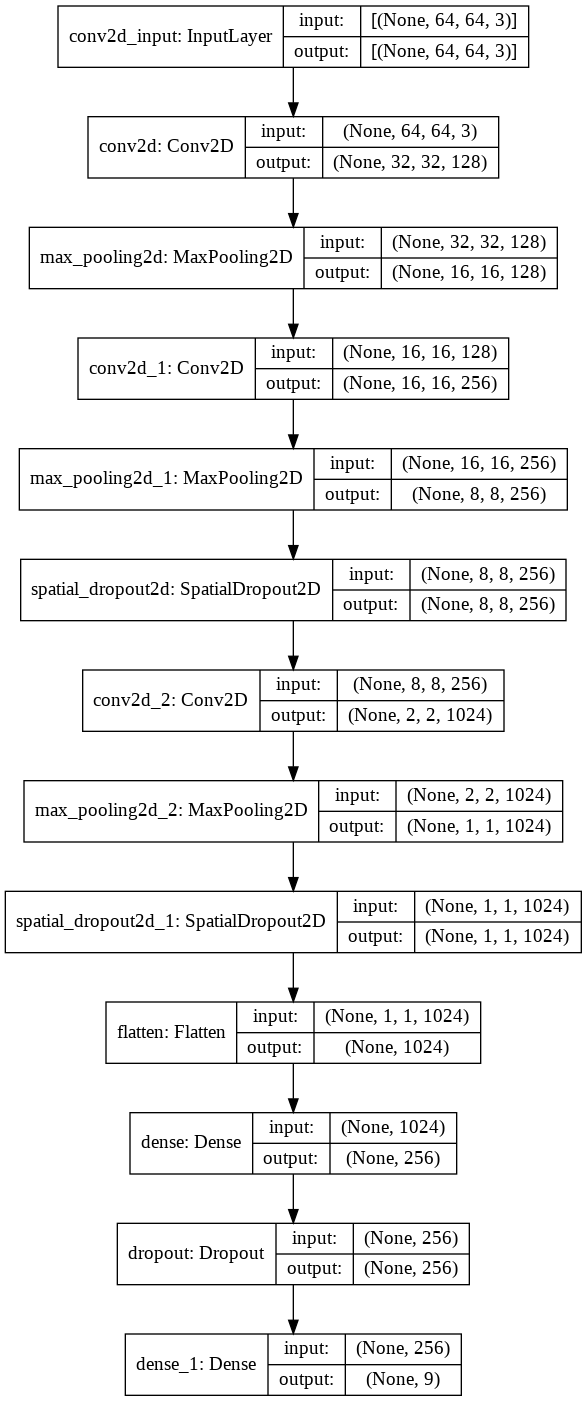

Model: "ensemble-base-model-0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 1024)        6554624   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 102

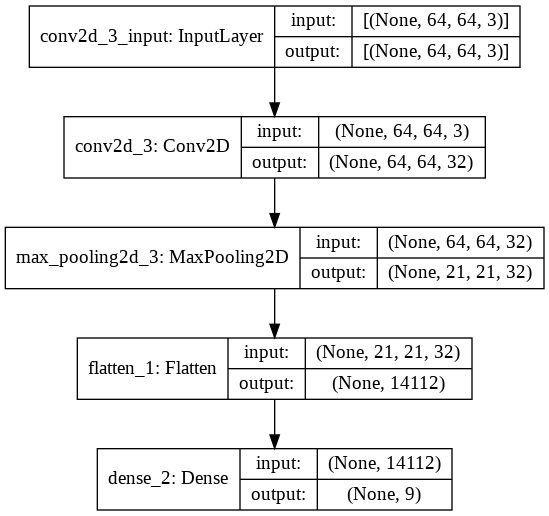

Model: "ensemble-base-model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14112)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 127017    
Total params: 127,433
Trainable params: 127,433
Non-trainable params: 0
_________________________________________________________________
None


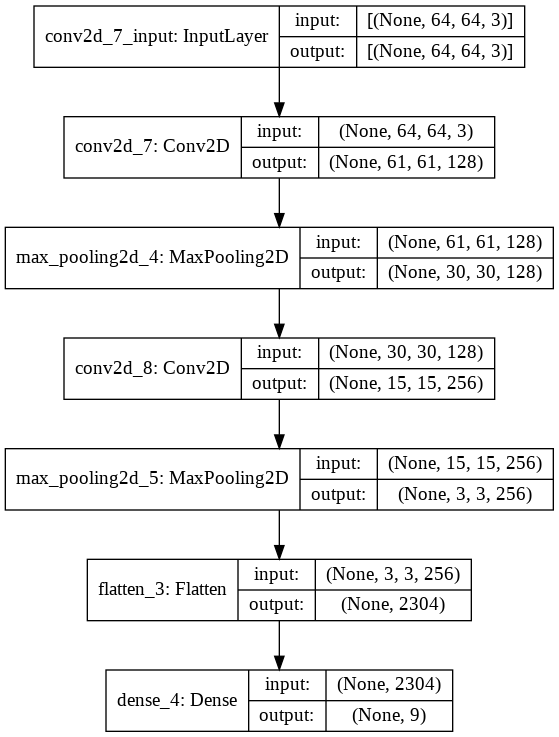

Model: "ensemble-base-model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 61, 61, 128)       6272      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 256)       131328    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 20745     
Total params: 158,345
Trainable params: 158,345
Non-trainable params: 0
_______________________________________

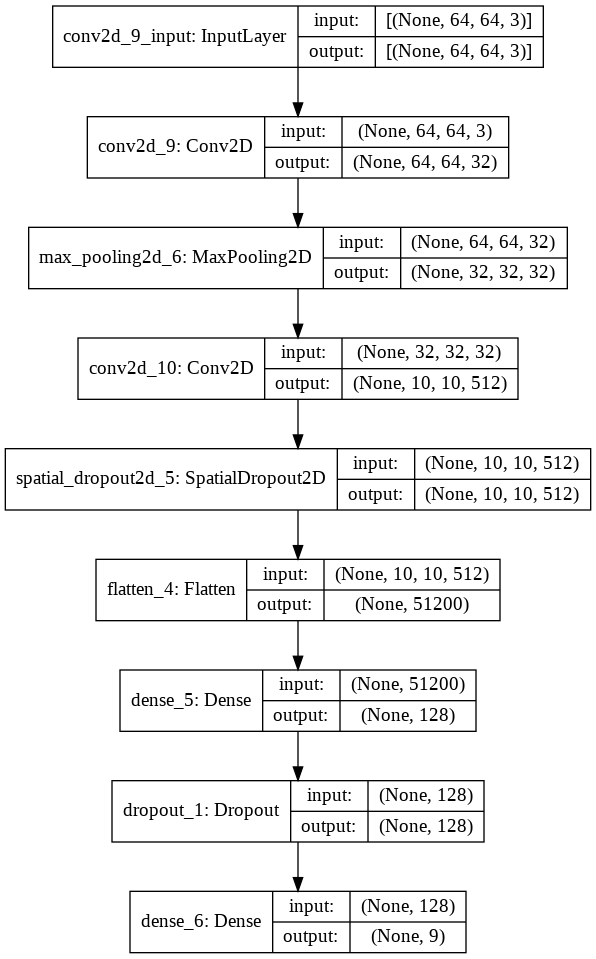

Model: "ensemble-base-model-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 512)       262656    
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 10, 10, 512)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               6553728   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)     

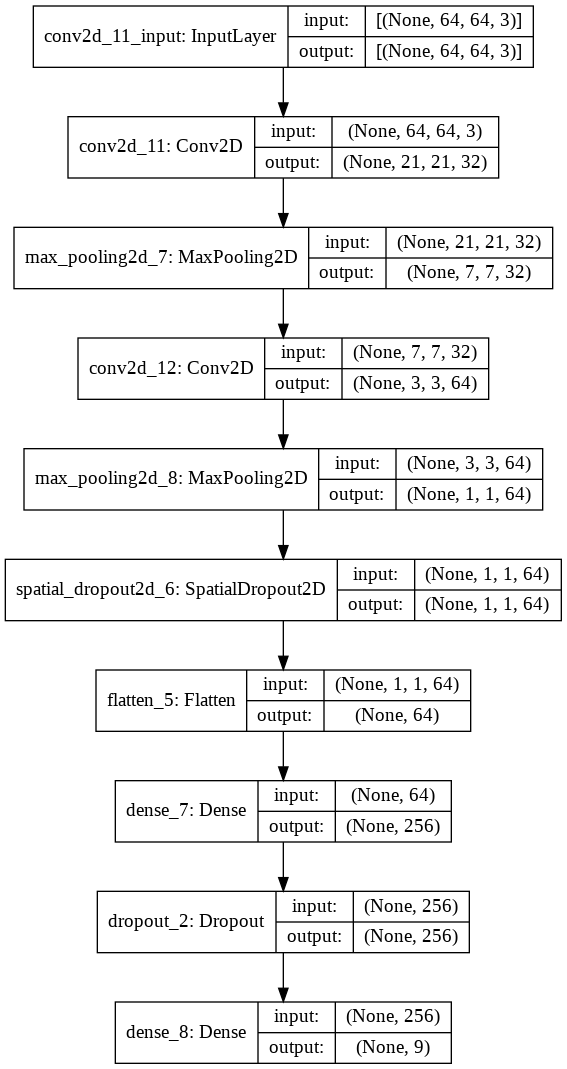

Model: "ensemble-base-model-4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 21, 21, 32)        1568      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 64)          8256      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
spatial_dropout2d_6 (Spatial (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)     

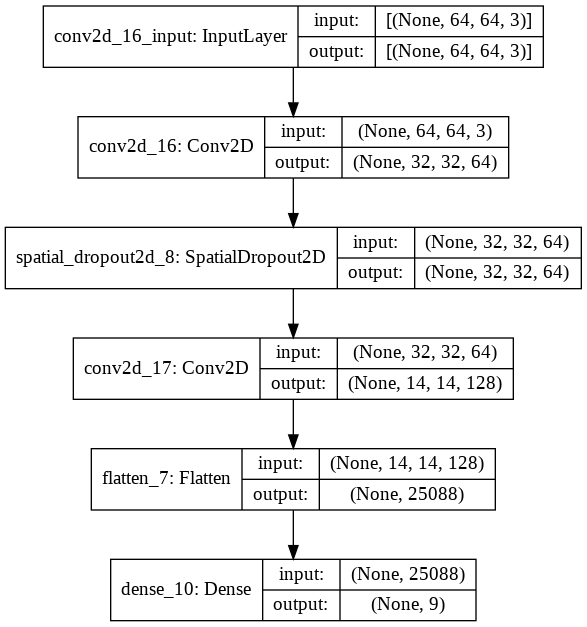

Model: "ensemble-base-model-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        832       
_________________________________________________________________
spatial_dropout2d_8 (Spatial (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 128)       204928    
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 9)                 225801    
Total params: 431,561
Trainable params: 431,561
Non-trainable params: 0
_________________________________________________________________
None


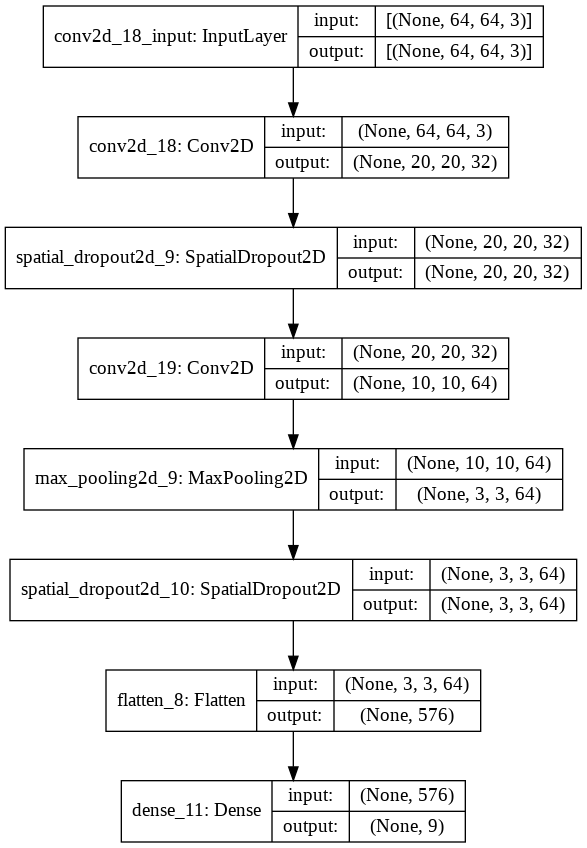

Model: "ensemble-base-model-6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 20, 20, 32)        2432      
_________________________________________________________________
spatial_dropout2d_9 (Spatial (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 10, 10, 64)        8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
spatial_dropout2d_10 (Spatia (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 9)       

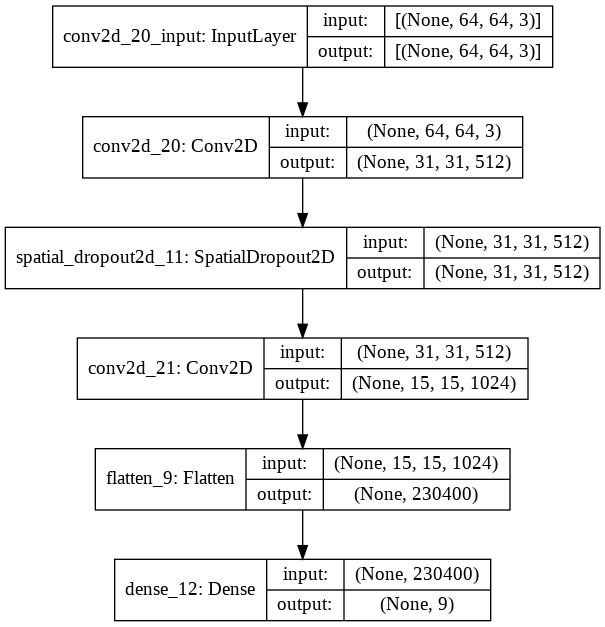

Model: "ensemble-base-model-7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 31, 31, 512)       25088     
_________________________________________________________________
spatial_dropout2d_11 (Spatia (None, 31, 31, 512)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 15, 15, 1024)      2098176   
_________________________________________________________________
flatten_9 (Flatten)          (None, 230400)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 2073609   
Total params: 4,196,873
Trainable params: 4,196,873
Non-trainable params: 0
_________________________________________________________________
None


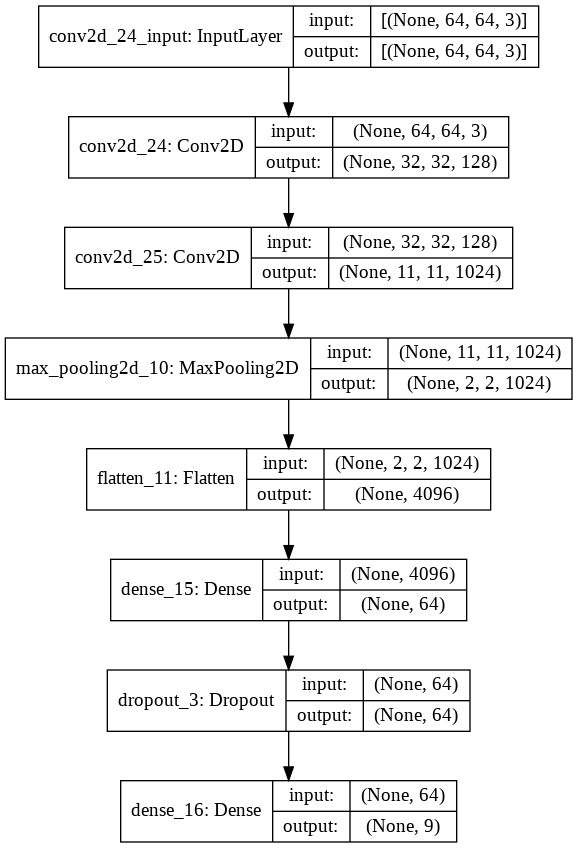

Model: "ensemble-base-model-8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 128)       1664      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 11, 11, 1024)      2098176   
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                262208    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 9)       

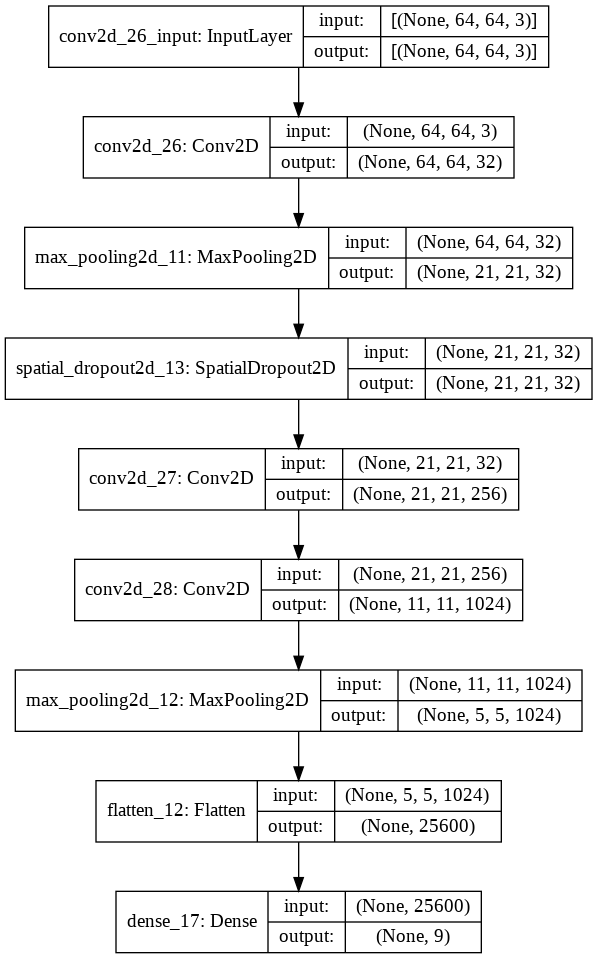

Model: "ensemble-base-model-9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
spatial_dropout2d_13 (Spatia (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 21, 21, 256)       205056    
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 1024)      4195328   
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 1024)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 25600)   

In [ ]:
gen_models()

In [ ]:
train_models()

Training all models ...
Training model 0

Model: "ensemble-base-model-0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 1024)        6554624   
_________________________________________________________________
max

In [ ]:
print("Evaluate and save ...")
evaluate_and_save_all()
print("Done")

Evaluate and save ...
--------------------- 0 -----------------------
--------------------- 1 -----------------------
2021-04-27 11:20:43,074 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.beta_1
2021-04-27 11:20:43,081 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.beta_2
2021-04-27 11:20:43,087 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.decay
2021-04-27 11:20:43,092 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.learning_rate
2021-04-27 11:20:43,096 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.iter
2021-04-27 11:20:43,101 - tensorflow - WARNING - A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or

# Run everything and compare

Done
    val_accuracies  train_accuracies  model_weights      model_names
0         0.806458          0.812708        7640457        Model - 0
1         0.759167          0.812292         127433        Model - 1
2         0.882500          0.907865         158345        Model - 2
3         0.125000          0.125000        6819977        Model - 3
4         0.653750          0.645885          28777        Model - 4
5         0.523750          0.549687         431561        Model - 5
6         0.644167          0.642500          15881        Model - 6
7         0.489375          0.530000        4196873        Model - 7
8         0.857917          0.910104        2362633        Model - 8
9         0.807083          0.907083        4631689        Model - 9
10        0.866875          0.911406              0  Simple Ensemble
11        0.905833          1.000000              0      RF Ensemble


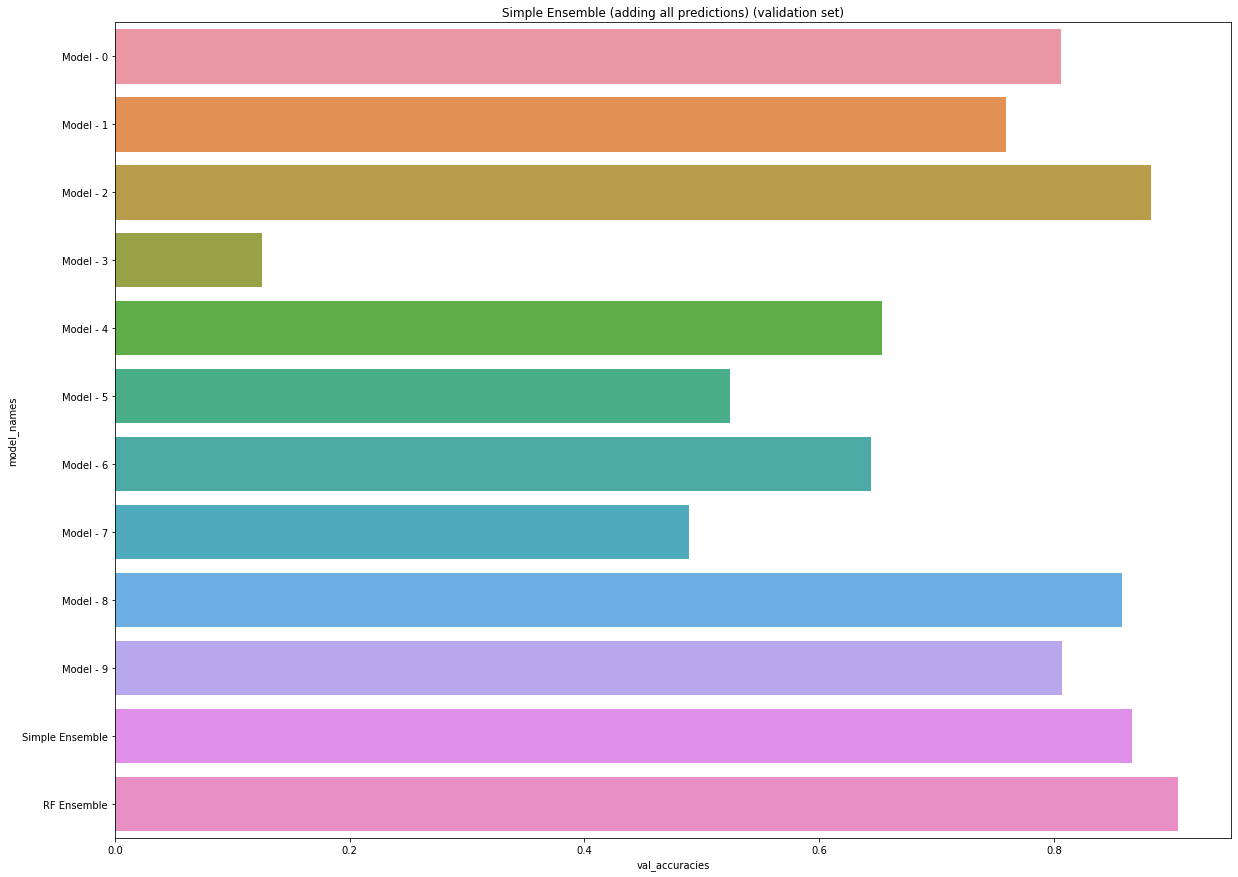

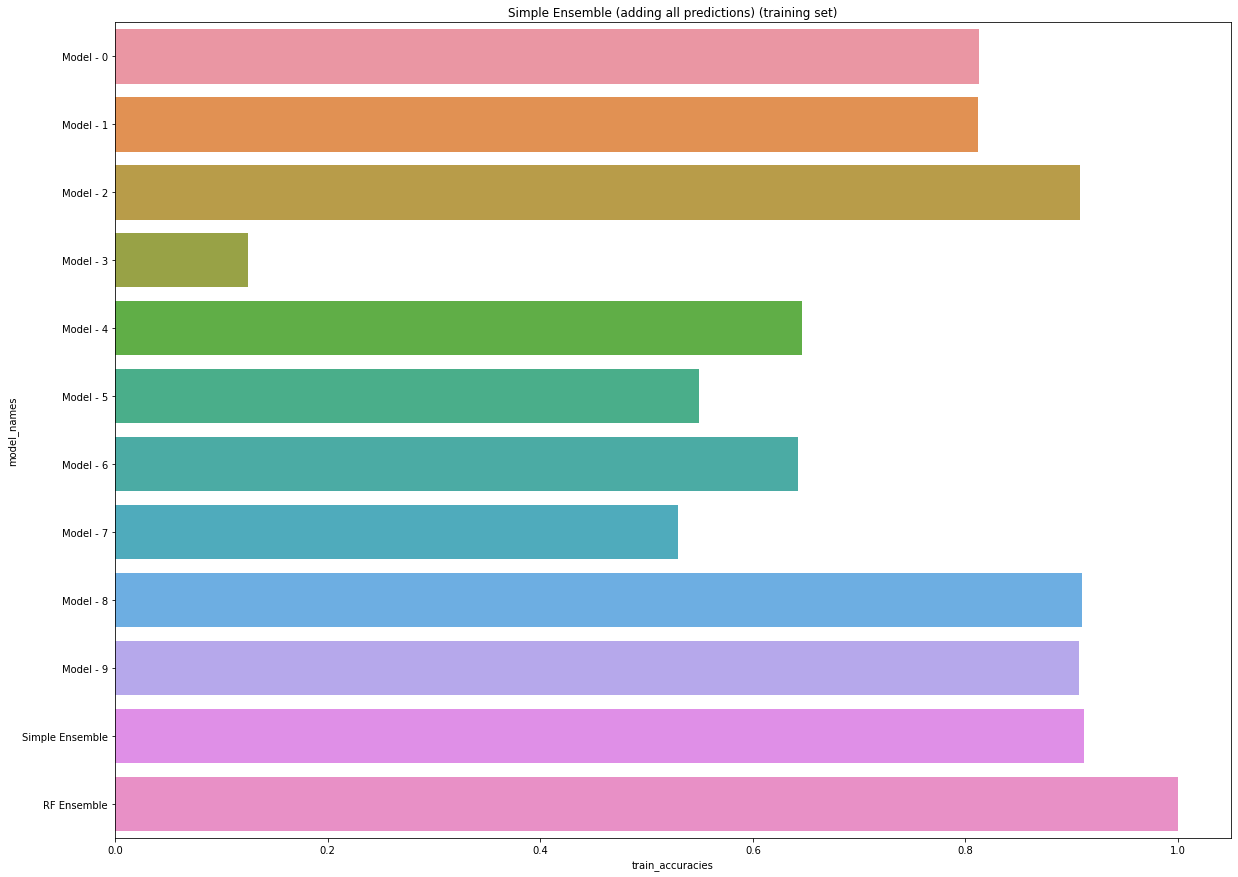

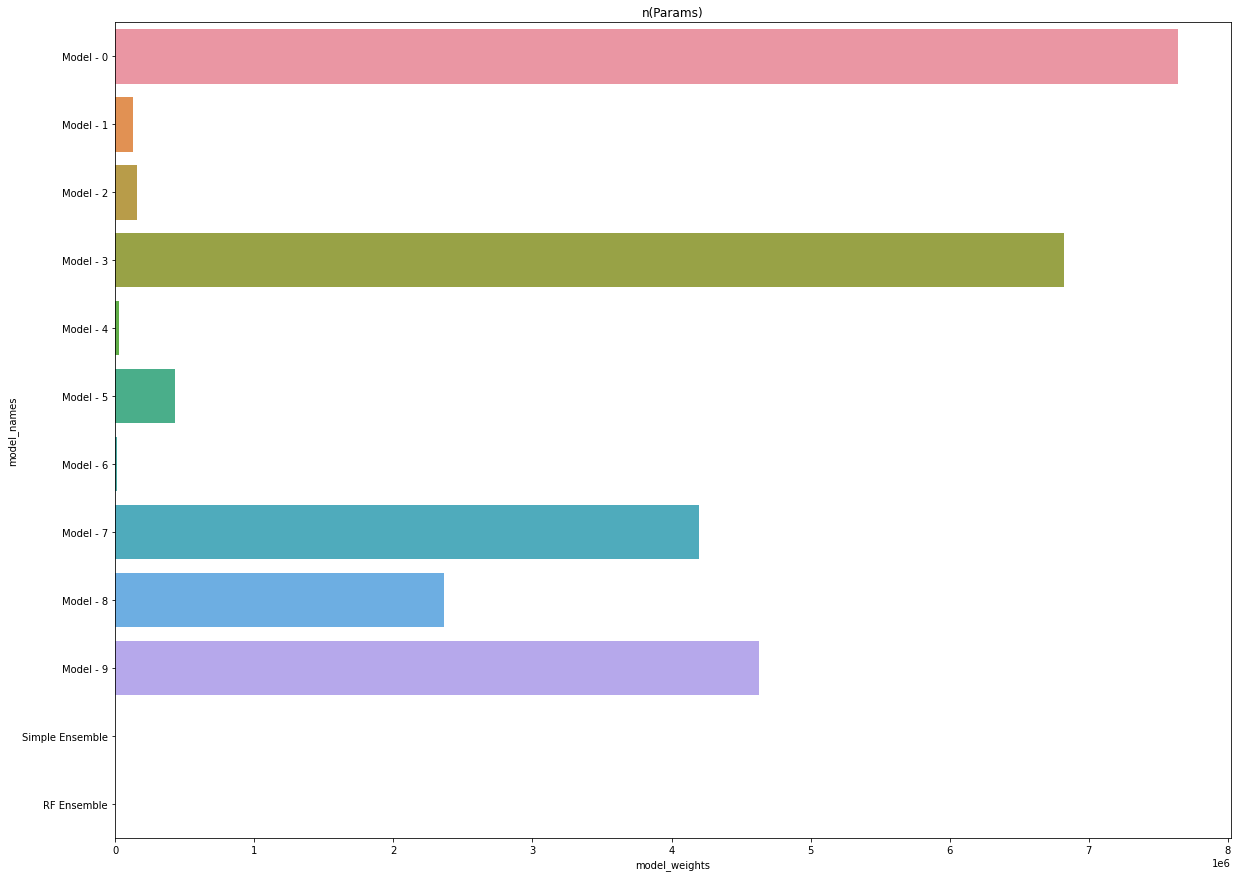

DecisionTreeClassifier : 0.8602083333333334
KNeighborsClassifier : 0.89875
NearestCentroid      : 0.87875
NaiveBayes           : 0.8635416666666667
SVC                  : 0.9020833333333333
Random Forest        : 0.9052083333333333
LDA                  : 0.8883333333333333
QDA                  : 0.874375
Logistic Regression  : 0.9014583333333334
Ridge                : 0.8914583333333334
Bagging              : 0.8895833333333333
SGD Classifier       : 0.896875
Passive Aggressive   : 0.8841666666666667
DecisionTreeClassifier 0.8602083333333334
KNeighborsClassifier 0.89875
NearestCentroid 0.87875
NaiveBayes 0.8635416666666667
SVC 0.9020833333333333
Random Forest 0.9052083333333333
LDA 0.8883333333333333
QDA 0.874375
Logistic Regression 0.9014583333333334
Ridge 0.8914583333333334
Bagging 0.8895833333333333
SGD Classifier 0.896875
Passive Aggressive 0.8841666666666667


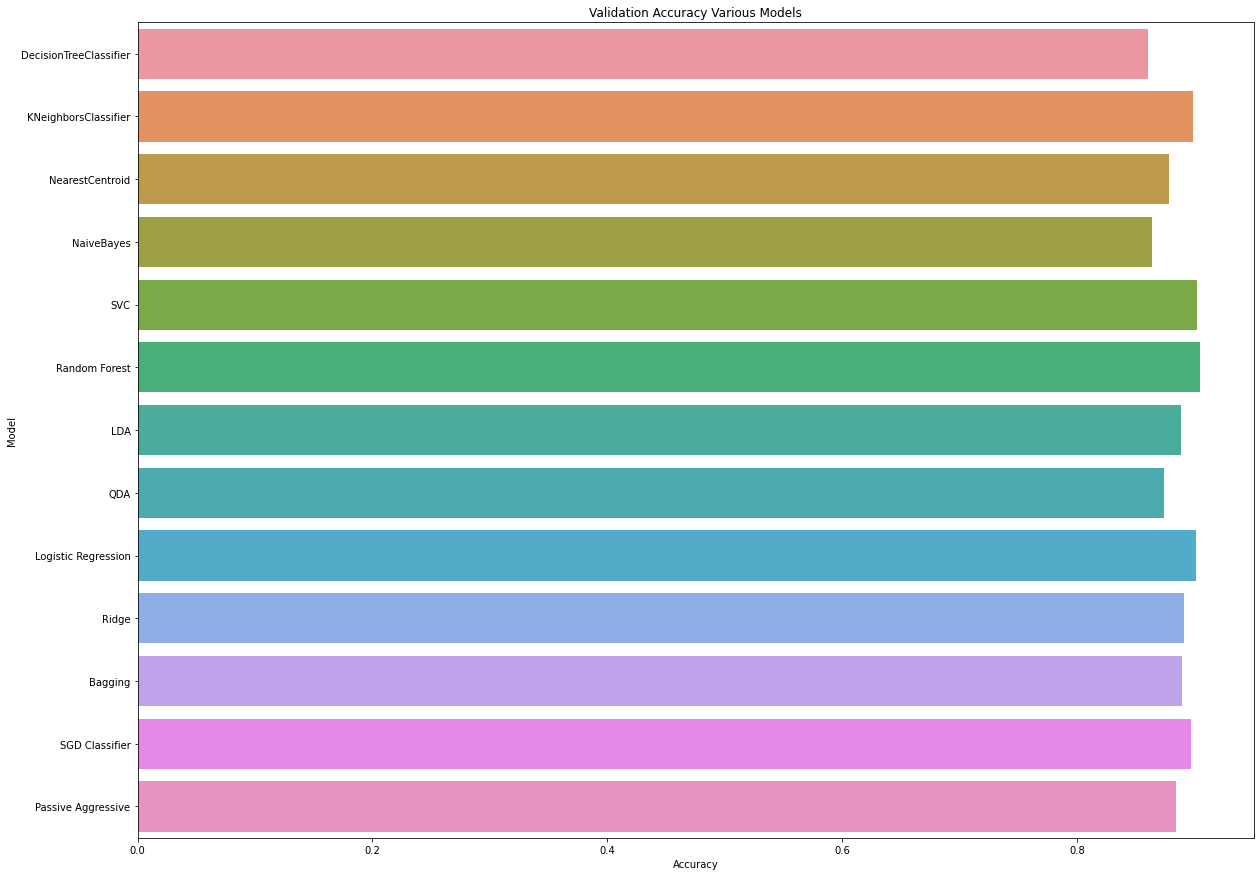

In [ ]:
run_ensemble()

In [ ]:
gc.collect()

2021-04-24 17:49:24,044 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.beta_1
2021-04-24 17:49:24,046 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.beta_2
2021-04-24 17:49:24,048 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.decay
2021-04-24 17:49:24,053 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.learning_rate
2021-04-24 17:49:24,057 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.iter
2021-04-24 17:49:24,060 - tensorflow - WARNING - A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/guide/checkpoint#loading_mechanics f

9743